# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model
import time

from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [2]:

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


In [3]:
X_features=np.load('X_gabor.npy')
y=np.load('y_tone.npy')

In [4]:
X_features.shape

(4704, 35, 7)

In [5]:
means = np.mean(X_features, axis=0)
X_features -= means
stds = np.std(X_features, axis=0)
X_features /= stds

In [6]:
# means = np.mean(X_features, axis=0)


## Encode label

In [7]:
le=LabelEncoder()
y=le.fit_transform(y)

In [8]:
print(y)

[0 3 3 ... 2 2 2]


In [9]:
CLASSES_LIST=le.classes_
print(CLASSES_LIST)

['1' '2' '3' '4']


## One-hot Encoding

In [10]:
y=to_categorical(y,num_classes=4)

In [11]:
y.shape

(4704, 4)

In [12]:
print(y)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [13]:
# y=y.reshape(4704,1,4)

In [14]:
y.shape

(4704, 4)

## split train and test

In [15]:
np.random.seed(116)
np.random.shuffle(X_features)
np.random.seed(116)
np.random.shuffle(y)
tf.random.set_seed(116)

In [16]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.2,random_state=2019)

In [17]:
X_train.shape,X_test.shape

((3763, 35, 7), (941, 35, 7))

# Models


In [38]:
NUM_CLASSES=4
BATCH_SIZE=32
EPOCHS=100
MODEL_SAVE_PATH='.\model\gabor_tone_cnn1.h5'

In [39]:
# layers.Dense(1, activation="sigmoid")

In [40]:
def attention_model():
    inputs = Input(shape=(35, 7))
    #x=BatchNormalization()(inputs)
    x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(inputs)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [41]:
model = attention_model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 64)       512         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 17, 64)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 17, 256)      197632      max_pooling1d_2[0][0]            
_______________________________________________________________________________________

In [42]:
# import pydotplus
# import graphviz 
# from keras.utils import plot_model
# plot_model(model, to_file='.\\Vedio_tone.png', show_shapes=True)

In [43]:
from keras import optimizers
adam=optimizers.Adam(learning_rate=0.001)

In [44]:
a=time.time()
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(model,'model_tune.jpg',show_shapes=True)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,
                  callbacks=callback_list)
b=time.time()
print("time=",b-a)

Epoch 1/100
91/95 [===========================>..] - ETA: 0s - loss: 1.3009 - accuracy: 0.3836
Epoch 00001: val_accuracy improved from -inf to 0.40372, saving model to .\model\gabor_tone_cnn1.h5
95/95 [==============================] - 2s 18ms/step - loss: 1.3015 - accuracy: 0.3850 - val_loss: 1.2564 - val_accuracy: 0.4037
Epoch 2/100
90/95 [===========================>..] - ETA: 0s - loss: 1.2389 - accuracy: 0.4236
Epoch 00002: val_accuracy improved from 0.40372 to 0.43028, saving model to .\model\gabor_tone_cnn1.h5
95/95 [==============================] - 1s 12ms/step - loss: 1.2407 - accuracy: 0.4199 - val_loss: 1.2410 - val_accuracy: 0.4303
Epoch 3/100
92/95 [============================>.] - ETA: 0s - loss: 1.2142 - accuracy: 0.4399
Epoch 00003: val_accuracy improved from 0.43028 to 0.43161, saving model to .\model\gabor_tone_cnn1.h5
95/95 [==============================] - 1s 12ms/step - loss: 1.2155 - accuracy: 0.4389 - val_loss: 1.2209 - val_accuracy: 0.4316
Epoch 4/100
93/95 [

Epoch 28/100
95/95 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.6415
Epoch 00028: val_accuracy did not improve from 0.50199
95/95 [==============================] - 1s 11ms/step - loss: 0.8468 - accuracy: 0.6415 - val_loss: 1.2282 - val_accuracy: 0.4794
Epoch 29/100
90/95 [===========================>..] - ETA: 0s - loss: 0.8241 - accuracy: 0.6653
Epoch 00029: val_accuracy did not improve from 0.50199
95/95 [==============================] - 1s 11ms/step - loss: 0.8255 - accuracy: 0.6645 - val_loss: 1.2332 - val_accuracy: 0.4874
Epoch 30/100
91/95 [===========================>..] - ETA: 0s - loss: 0.8154 - accuracy: 0.6672
Epoch 00030: val_accuracy did not improve from 0.50199
95/95 [==============================] - 1s 12ms/step - loss: 0.8167 - accuracy: 0.6661 - val_loss: 1.2389 - val_accuracy: 0.4648
Epoch 31/100
93/95 [============================>.] - ETA: 0s - loss: 0.7917 - accuracy: 0.6640
Epoch 00031: val_accuracy did not improve from 0.50199
95/95 

Epoch 57/100
94/95 [============================>.] - ETA: 0s - loss: 0.4478 - accuracy: 0.8245
Epoch 00057: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 12ms/step - loss: 0.4477 - accuracy: 0.8246 - val_loss: 1.5702 - val_accuracy: 0.4622
Epoch 58/100
94/95 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.8388
Epoch 00058: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 12ms/step - loss: 0.4313 - accuracy: 0.8389 - val_loss: 1.5487 - val_accuracy: 0.4861
Epoch 59/100
91/95 [===========================>..] - ETA: 0s - loss: 0.4122 - accuracy: 0.8400
Epoch 00059: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 11ms/step - loss: 0.4142 - accuracy: 0.8395 - val_loss: 1.5644 - val_accuracy: 0.4648
Epoch 60/100
91/95 [===========================>..] - ETA: 0s - loss: 0.4061 - accuracy: 0.8492
Epoch 00060: val_accuracy did not improve from 0.50465
95/95 

91/95 [===========================>..] - ETA: 0s - loss: 0.2557 - accuracy: 0.9014
Epoch 00086: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 12ms/step - loss: 0.2558 - accuracy: 0.9010 - val_loss: 1.9258 - val_accuracy: 0.4515
Epoch 87/100
92/95 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9164
Epoch 00087: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 11ms/step - loss: 0.2284 - accuracy: 0.9166 - val_loss: 1.9031 - val_accuracy: 0.4502
Epoch 88/100
91/95 [===========================>..] - ETA: 0s - loss: 0.2171 - accuracy: 0.9255
Epoch 00088: val_accuracy did not improve from 0.50465
95/95 [==============================] - 1s 11ms/step - loss: 0.2172 - accuracy: 0.9266 - val_loss: 1.9186 - val_accuracy: 0.4542
Epoch 89/100
92/95 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.9120
Epoch 00089: val_accuracy did not improve from 0.50465
95/95 [============

## plot_curve

In [47]:
# from keras.models import load_model
model=load_model('.\model\gabor_tone_cnn1.h5')
# history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
#                   callbacks=callback_list)

In [25]:
from help import plot_curve,plot_curve_with_smooth
plot_curve(history)
plot_curve_with_smooth(history)

<Figure size 1500x500 with 2 Axes>

<Figure size 1500x500 with 2 Axes>

## confusion_metrix

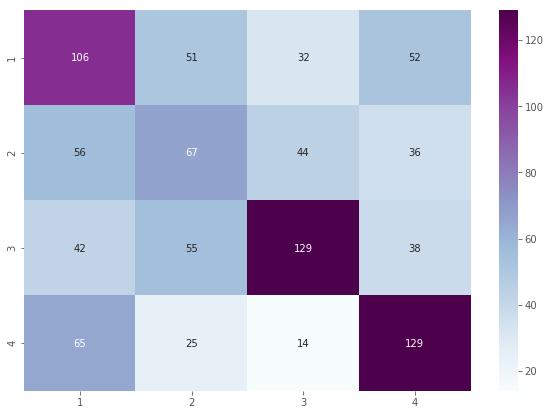

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
# def plot_confusion_matrix(confusion_mat):
#     plt.imshow(confusion_mat)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
labels = [1,2,3,4]
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.grid(False)
#     plt.show() 
# plot_confusion_matrix(con_matrix)
import seaborn as sn

df_cm = pd.DataFrame(con_matrix,
                     index = [i for i in list(labels)],
                     columns = [i for i in list(labels)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.20g',cmap="BuPu")

## classfication_report

In [27]:
from sklearn.metrics import classification_report


In [28]:
target_names = ['1', '2', '3','4']
print(classification_report(y_true,y_pred,digits=4,labels=[0,1,2,3],target_names=target_names))

              precision    recall  f1-score   support

           1     0.3941    0.4398    0.4157       241
           2     0.3384    0.3300    0.3342       203
           3     0.5890    0.4886    0.5342       264
           4     0.5059    0.5536    0.5287       233

   micro avg     0.4580    0.4580    0.4580       941
   macro avg     0.4568    0.4530    0.4532       941
weighted avg     0.4644    0.4580    0.4593       941



# predict

Test Che1.npy

In [48]:
temp = np.load('che1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

(1, 35, 7)
Predict Label:3


Other tests

In [20]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [21]:
wav_file='./voice_data/person10_time1_group1_ba_1.wav'

In [22]:
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

Predict Label:1


In [40]:
temp = np.load('./gabor/person2_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

(1, 35, 7)
Predict Label:4


In [63]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])